In [1]:
!pip install -q kaggle lightgbm imbalanced-learn scikit-learn pandas matplotlib

import os, zipfile, json, warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.svm import SVC
warnings.filterwarnings("ignore")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 17.7 MB/s eta 0:00:00


In [3]:
# 1️⃣  Upload kaggle.json (Colab: Files sidebar ▸ Upload)
from google.colab import files, drive
files.upload()                            # choose kaggle.json

# 2️⃣  Move it to the hidden Kaggle folder and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [4]:
# 3️⃣  Pull the Lending Club zip (≈ 5 GB)
!kaggle datasets download -d wordsforthewise/lending-club -p /content

# 4️⃣  Unzip only the accepted-loans CSV (saves RAM)
import zipfile, re, os
with zipfile.ZipFile('/content/lending-club.zip') as z:
    file = [f for f in z.namelist() if re.search(r'accepted_2007.*csv$', f)][0]
    z.extract(file, '/content')
csv_path = '/content/' + file
print("CSV ready →", csv_path)


Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
 96% 1.21G/1.26G [00:01<00:00, 1.17GB/s]
100% 1.26G/1.26G [00:01<00:00, 1.18GB/s]
CSV ready → /content/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv


In [5]:
import pandas as pd

# Load the dataset (can take a few seconds to minutes)
df = pd.read_csv(csv_path, low_memory=False)





In [9]:
# Filter necessary columns only
target = 'loan_status'
features = [
    'loan_amnt','term','grade','sub_grade','emp_length','home_ownership',
    'annual_inc','purpose','addr_state','dti','delinq_2yrs','inq_last_6mths',
    'open_acc','pub_rec','revol_util','total_acc','application_type'
]

df = df[features + [target]]

In [12]:
# Convert target to binary: 1 = Default, 0 = Fully Paid
bad_status = ['Charged Off','Default','Does not meet the credit policy. Status:Charged Off']
df = df[df[target].isin(bad_status + ['Fully Paid'])]
df[target] = df[target].apply(lambda x: 1 if x in bad_status else 0)

# Drop columns with >25% missing
df = df.dropna(axis=1, thresh=len(df)*0.75)

# Fill remaining missing values
df = df.fillna(df.median(numeric_only=True))
df = df.fillna('Unknown')


In [8]:
df = pd.read_csv(csv_path, parse_dates=['issue_d'])
df = df[df['issue_d'].dt.year == 2018]      # or 2019 if available


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# One-hot encode categorical variables
X = pd.get_dummies(df.drop(target, axis=1), drop_first=True)
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y)

# Balance using SMOTE
sm = SMOTE(random_state=10)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scale for SVM (not needed for LightGBM)
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_res)
X_test_svm = scaler.transform(X_test)


In [15]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# Train
lgb_train = lgb.Dataset(X_train_res, label=y_train_res)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbosity': -1
}
gbm = lgb.train(params, lgb_train, num_boost_round=30)

# Predict
y_pred_lgb = (gbm.predict(X_test) > 0.5).astype(int)
print("LightGBM Results:\n", classification_report(y_test, y_pred_lgb))


LightGBM Results:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      9489
           1       0.48      0.05      0.08      1775

    accuracy                           0.84     11264
   macro avg       0.66      0.52      0.50     11264
weighted avg       0.79      0.84      0.78     11264



In [17]:
from sklearn.svm import SVC

# Train
svm = SVC(C=5, kernel='rbf')
svm.fit(X_train_svm, y_train_res)

# Predict
y_pred_svm = svm.predict(X_test_svm)
print("SVM Results:\n", classification_report(y_test, y_pred_svm))


SVM Results:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      9489
           1       0.38      0.05      0.08      1775

    accuracy                           0.84     11264
   macro avg       0.62      0.52      0.50     11264
weighted avg       0.77      0.84      0.78     11264



In [18]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def show_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=['Actual Paid', 'Actual Default'],
                         columns=['Pred Paid', 'Pred Default'])
    print(f"\nConfusion Matrix for {model_name}")
    print(df_cm)

show_conf_matrix(y_test, y_pred_lgb, "LightGBM")
show_conf_matrix(y_test, y_pred_svm, "SVM")



Confusion Matrix for LightGBM
                Pred Paid  Pred Default
Actual Paid          9403            86
Actual Default       1695            80

Confusion Matrix for SVM
                Pred Paid  Pred Default
Actual Paid          9356           133
Actual Default       1692            83


In [19]:
print("LightGBM  report ⬇︎")
print(classification_report(y_test, y_pred_lgb, digits=3))

print("\nSVM report ⬇︎")
print(classification_report(y_test, y_pred_svm, digits=3))


LightGBM  report ⬇︎
              precision    recall  f1-score   support

           0      0.847     0.991     0.913      9489
           1      0.482     0.045     0.082      1775

    accuracy                          0.842     11264
   macro avg      0.665     0.518     0.498     11264
weighted avg      0.790     0.842     0.783     11264


SVM report ⬇︎
              precision    recall  f1-score   support

           0      0.847     0.986     0.911      9489
           1      0.384     0.047     0.083      1775

    accuracy                          0.838     11264
   macro avg      0.616     0.516     0.497     11264
weighted avg      0.774     0.838     0.781     11264



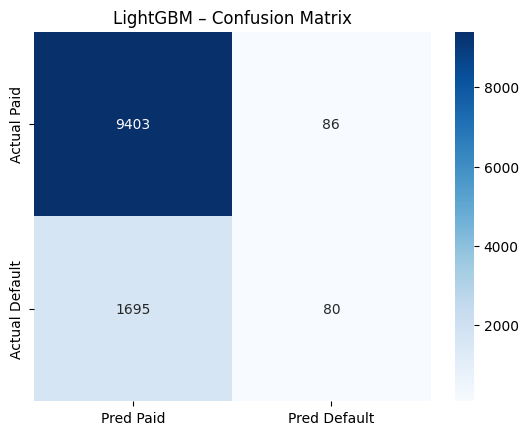

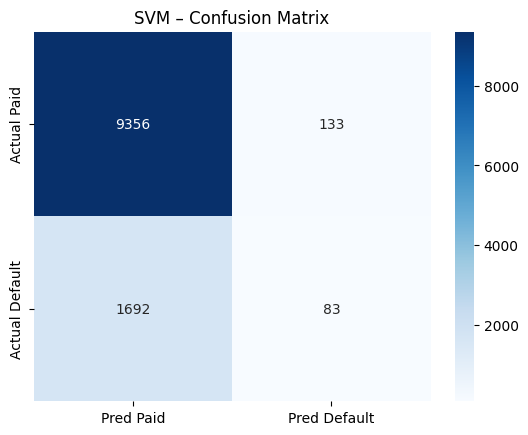

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm,
        index=['Actual Paid', 'Actual Default'],
        columns=['Pred Paid', 'Pred Default'])
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title); plt.xlabel(""); plt.ylabel("")
    plt.show()

plot_cm(y_test, y_pred_lgb, "LightGBM – Confusion Matrix")
plot_cm(y_test, y_pred_svm,  "SVM – Confusion Matrix")


In [21]:
# Get probabilities instead of hard 0/1 labels
proba = gbm.predict(X_test)          # float ∈ [0,1]

# Create a tidy DataFrame to inspect
inspect = (pd.DataFrame({
            'prob_default': proba,
            'actual': y_test})
           .reset_index(drop=True)
           .sort_values('prob_default', ascending=False))

print(inspect.head(10))              # top-10 riskiest loans


       prob_default  actual
5337       0.562998       0
3611       0.558968       1
1098       0.558968       1
4942       0.558882       0
5676       0.553601       1
8965       0.553601       1
5261       0.553601       1
10095      0.553601       1
11232      0.553601       1
4888       0.551110       1


ROC-AUC: 0.693


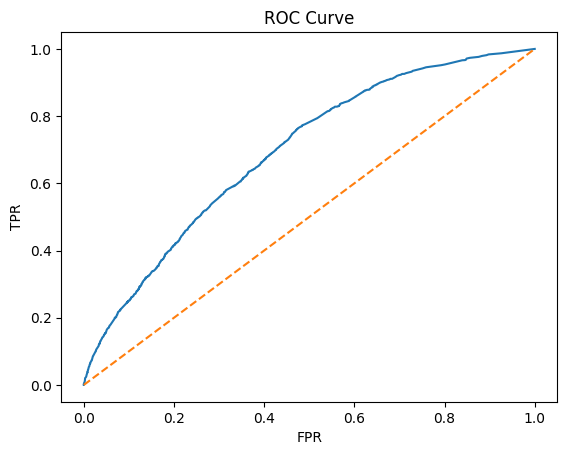

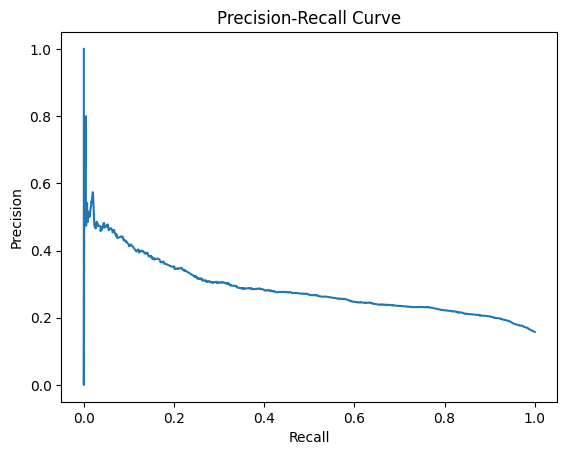

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

auc = roc_auc_score(y_test, proba)
print("ROC-AUC:", round(auc,3))

fpr, tpr, _ = roc_curve(y_test, proba)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

prec, rec, thresh = precision_recall_curve(y_test, proba)
plt.plot(rec, prec); plt.title("Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()


In [23]:
new_app = {
    'loan_amnt': 15000, 'term': ' 36 months', 'grade': 'C', 'sub_grade': 'C3',
    'emp_length': '3 years', 'home_ownership': 'MORTGAGE',
    'annual_inc': 55000, 'purpose': 'credit_card', 'addr_state': 'TX',
    'dti': 18.5, 'delinq_2yrs': 0, 'inq_last_6mths': 1,
    'open_acc': 12, 'pub_rec': 0, 'revol_util': 68.2,
    'total_acc': 25, 'application_type': 'Individual'
}

# turn into 1-row DataFrame, one-hot it, align columns
x_new = (pd.DataFrame([new_app])
         .pipe(pd.get_dummies, drop_first=True)
         .reindex(columns=X.columns, fill_value=0))

print("Probability of default:", gbm.predict(x_new)[0].round(3))


Probability of default: 0.173
